In [1]:
import os
import sys

import itertools
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

sys.path.append('../')
import utils
%matplotlib inline

In [2]:
root_folder = 'FMNIST_fc_results'
random_folder = root_folder + '/Random_results'
fixed_folder = root_folder + '/Fixed_results'

if not os.path.isdir(root_folder):
    os.mkdir(root_folder)
if not os.path.isdir(random_folder):
    os.mkdir(random_folder)
if not os.path.isdir(fixed_folder):
    os.mkdir(fixed_folder)

In [3]:
lr = 0.001
prior_size = 16
batch_size = 256
train_epoch = 200

In [5]:
normalize = ((0.5,), (0.5,))
train_loader = utils.loader(batch_size=batch_size, train=True, normalize=normalize, fashion=True, path='./fdataset')
test_loader = utils.loader(batch_size=batch_size, train=False, normalize=normalize, fashion=True, path='./fdataset')

In [6]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform(m.weight.data)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1.0)
        m.bias.data.fill_(0)

In [7]:
class Net(nn.Module):
    def __init__(self, isBN=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 256)
        self.fc3 = nn.Linear(self.fc2.out_features, 64)
        self.fc4 = nn.Linear(self.fc3.out_features, 10)
        
        self.isBN = isBN
        if isBN:
            self.bn1 = nn.BatchNorm1d(self.fc1.out_features)
            self.bn2 = nn.BatchNorm1d(self.fc2.out_features)
            self.bn3 = nn.BatchNorm1d(self.fc3.out_features)
        
    def forward(self, x):
        x = self.fc1(x)
        if self.isBN:
            x = self.bn1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        if self.isBN:
            x = self.bn2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        if self.isBN:
            x = self.bn3(x)
        x = F.relu(x)
        
        x = F.log_softmax(self.fc4(x), 1)
        return x

In [8]:
model = Net()

he_model = Net()
he_model.apply(weights_init)

bn_model = Net(True)

basic_opt = optim.SGD(model.parameters(), lr=lr)
he_opt = optim.SGD(he_model.parameters(), lr=lr)
bn_opt = optim.SGD(bn_model.parameters(), lr=lr)

In [9]:
def step(model, optimizer, x, y):
    optimizer.zero_grad()
    output = model(x)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def train(epoch):
    average_loss = 0
    average_he = 0
    average_bn = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        basic_loss = step(model, basic_opt, x, y)
        he_loss = step(he_model, he_opt, x, y)
        bn_loss = step(bn_model, bn_opt, x, y)
        average_loss += basic_loss * len(x)
        average_he += he_loss * len(x)
        average_bn += bn_loss * len(x)
    else:
        average_loss /= len(train_loader.dataset)
        average_he /= len(train_loader.dataset)
        average_bn /= len(train_loader.dataset)
        batch_idx += 1
        print('Train Epoch: {}\tLoss: {:.6f}|{:.6f}|{:.6f}'.format(epoch, average_loss, average_he, average_bn))
        
def test(log):
    bn_model.eval()
    test_loss, he_test_loss, bn_test_loss = 0, 0, 0
    correct, he_correct, bn_correct = [0, 0, 0]
    for x, y in test_loader:
        x = x.view(-1, 784)
        x, y = Variable(x, volatile=True), Variable(y)
        
        basic_output = model(x)
        he_output = he_model(x)
        bn_output = bn_model(x)
        
        test_loss += F.nll_loss(basic_output, y, size_average=False).data[0]
        he_test_loss += F.nll_loss(he_output, y, size_average=False).data[0]
        bn_test_loss += F.nll_loss(bn_output, y, size_average=False).data[0]
                
        pred = basic_output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y.data.view_as(pred)).sum()
        
        pred = he_output.data.max(1, keepdim=True)[1]
        he_correct += pred.eq(y.data.view_as(pred)).sum()
        
        pred = bn_output.data.max(1, keepdim=True)[1]
        bn_correct += pred.eq(y.data.view_as(pred)).sum()
        
    test_loss /= len(test_loader.dataset)
    he_test_loss /= len(test_loader.dataset)
    bn_test_loss /= len(test_loader.dataset)
    
    correct_pct = 100. * correct / len(test_loader.dataset)
    he_correct_pct = 100. * he_correct / len(test_loader.dataset)
    bn_correct_pct = 100. * bn_correct / len(test_loader.dataset)
    
    log['basic'].append((test_loss, correct_pct))
    log['he'].append((he_test_loss, he_correct_pct))
    log['bn'].append((bn_test_loss, bn_correct_pct))
    
    print('\nBasic Model: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, 
                                                                                  len(test_loader.dataset),
                                                                                  correct_pct))
    print('He Model: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(he_test_loss, he_correct, 
                                                                             len(test_loader.dataset),
                                                                             he_correct_pct))
    print('BN Model: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(bn_test_loss, bn_correct, 
                                                                               len(test_loader.dataset),
                                                                               bn_correct_pct))
    bn_model.train()

In [10]:
err_log = {'basic': [], 'he': [], 'bn': []}

for epoch in range(1, 51):
    train(epoch)
    test(err_log)

Train Epoch: 1	Loss: 2.293340|1.535755|1.986661

Basic Model: Average loss: 2.2825, Accuracy: 1002/10000 (10%)
He Model: Average loss: 1.1177, Accuracy: 6697/10000 (67%)
BN Model: Average loss: 1.8162, Accuracy: 6465/10000 (65%)

Train Epoch: 2	Loss: 2.271556|0.952384|1.725541

Basic Model: Average loss: 2.2598, Accuracy: 1799/10000 (18%)
He Model: Average loss: 0.8671, Accuracy: 7261/10000 (73%)
BN Model: Average loss: 1.6483, Accuracy: 7158/10000 (72%)

Train Epoch: 3	Loss: 2.247386|0.789302|1.581489

Basic Model: Average loss: 2.2336, Accuracy: 2159/10000 (22%)
He Model: Average loss: 0.7654, Accuracy: 7490/10000 (75%)
BN Model: Average loss: 1.5233, Accuracy: 7429/10000 (74%)

Train Epoch: 4	Loss: 2.218190|0.711033|1.463852

Basic Model: Average loss: 2.2007, Accuracy: 2545/10000 (25%)
He Model: Average loss: 0.7081, Accuracy: 7608/10000 (76%)
BN Model: Average loss: 1.4141, Accuracy: 7632/10000 (76%)

Train Epoch: 5	Loss: 2.180577|0.662432|1.361342

Basic Model: Average loss: 2.15

Train Epoch: 37	Loss: 0.681079|0.410804|0.417062

Basic Model: Average loss: 0.6921, Accuracy: 7477/10000 (75%)
He Model: Average loss: 0.4542, Accuracy: 8388/10000 (84%)
BN Model: Average loss: 0.4451, Accuracy: 8643/10000 (86%)

Train Epoch: 38	Loss: 0.672943|0.408759|0.410164

Basic Model: Average loss: 0.6849, Accuracy: 7501/10000 (75%)
He Model: Average loss: 0.4514, Accuracy: 8389/10000 (84%)
BN Model: Average loss: 0.4420, Accuracy: 8646/10000 (86%)

Train Epoch: 39	Loss: 0.665425|0.406761|0.403283

Basic Model: Average loss: 0.6780, Accuracy: 7507/10000 (75%)
He Model: Average loss: 0.4502, Accuracy: 8399/10000 (84%)
BN Model: Average loss: 0.4360, Accuracy: 8648/10000 (86%)

Train Epoch: 40	Loss: 0.658346|0.404746|0.398009

Basic Model: Average loss: 0.6720, Accuracy: 7518/10000 (75%)
He Model: Average loss: 0.4491, Accuracy: 8397/10000 (84%)
BN Model: Average loss: 0.4307, Accuracy: 8658/10000 (87%)

Train Epoch: 41	Loss: 0.651729|0.402857|0.392346

Basic Model: Average loss:

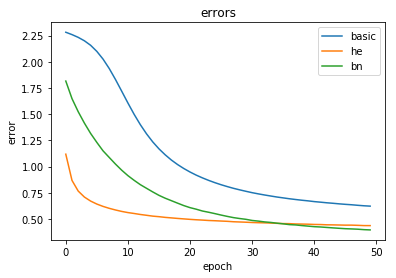

In [11]:
utils.plot_graphs(err_log, 'loss')

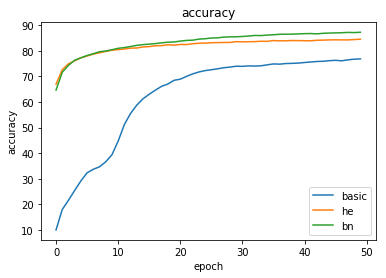

In [12]:
utils.plot_graphs(err_log, 'accuracy')